In [ ]:
# For colab training
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# repo_path = '/content/drive/MyDrive/projects/Celpose'
# if not os.path.exists(repo_path):
#     os.makedirs(repo_path)
# os.chdir(repo_path)

# !pip install cellpose

In [5]:
image_input_file = r"G:/Alexis_data/Project/FISH/output/Heart2_round2/cropped_section_10.tif"

In [6]:
import tifffile
import matplotlib.pyplot as plt

# Read the image
img = tifffile.imread(image_input_file)

# Print the shape of the image
print(f"Image shape: {img.shape}")


Image shape: (519, 810, 803)


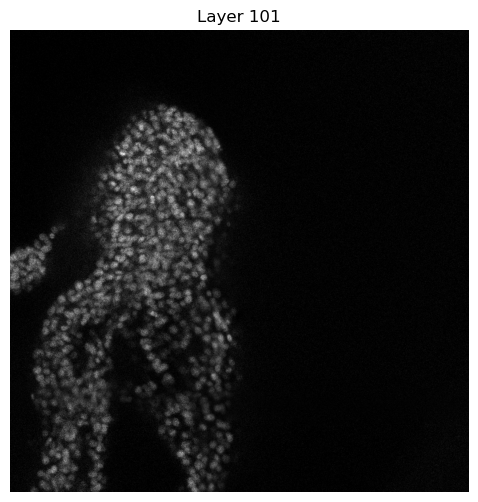

In [7]:
# Specify the layer index to visualize (0-based indexing)
layer_index = 100  # Change this to the specific layer you want to visualize

# Check if the layer index is within bounds
if 0 <= layer_index < img.shape[0]:
    plt.figure(figsize=(6, 6))
    plt.imshow(img[layer_index, :, :], cmap='gray')
    plt.title(f'Layer {layer_index + 1}')
    plt.axis('off')
    plt.show()
else:
    print(f"Invalid layer index: {layer_index}. Please choose a value between 0 and {img.shape[0] - 1}.")


In [9]:
from cellpose import denoise, models, io

In [21]:

# model set up
denoise_model = denoise.DenoiseModel(gpu=True, model_type='denoise_nuclei',  diam_mean=20.0)
model = models.CellposeModel(gpu=True, model_type = "nuclei" , diam_mean=20.0)

# cellpose denoise and segmentation procedure
print("input image shape is: ", img.shape)



# denoise
imgs_dn = denoise_model.eval(img, batch_size=4,
                            channel_axis=None,
                            # z_axis=0,
                            normalize=True,
                            rescale=None,
                            diameter=20,
                            tile=True,
                            do_3D=True,
                            tile_overlap=0.1,
                            bsize=224)

# segmentation
masks, flows, styles = model.eval(
    x=imgs_dn,  # Your input image array
    batch_size=4,
    do_3D=True,       # Enable 3D segmentation
    diameter=20.0,
    channel_axis = None,
    # anisotropy=2.0    # Adjust anisotropy if needed
)

print("output image shape is: ", masks.shape)

# save the masks as tif file
io.save_masks(
    images=[img],  # List containing the image
    masks=[masks],            # List containing the mask
    flows=[flows],            # List containing the flows
    file_names=['output/Cellpose_output/Heart_region_10'],  # Base filename for saving
    png=False,                # Disable saving as PNG
    tif=True,                 # Enable saving as TIFF
    channels=[0, 0],           # Channels used in Cellpose
    # ... other parameters if needed ...
)

print(f"Mask number n saved as 'cp_masks_{img_name}.tif'")




In [1]:
# Export of npy files doesn't work cause high running memory require

# from cellpose import models, io

# # ... (your previous code for loading the image and running Cellpose) ...

# # Save the segmentation output
# io.masks_flows_to_seg(
#     images=[img],  # List containing the image
#     masks=[masks],            # List containing the mask
#     flows=[flows],            # List containing the flows
#     file_names=['/content/drive/MyDrive/projects/Cellpose/output/section10_segmented_output'],  # Base filename for saving
#     diams=30.0,              # Diameter used in Cellpose

# )

# print("Segmentation output saved to 'segmented_output_seg.npy'")

In [18]:
io.save_masks(
    images=[img],  # List containing the image
    masks=[masks],            # List containing the mask
    flows=[flows],            # List containing the flows
    file_names=['output/Cellpose_output/Heart_region_10'],  # Base filename for saving
    png=False,                # Disable saving as PNG
    tif=True,                 # Enable saving as TIFF
    channels=[0, 0],           # Channels used in Cellpose
    # ... other parameters if needed ...
)
    
print("Mask saved as 'segmented_output_cp_masks.tif'")

print("Segmentation output saved as tif")

Mask saved as 'segmented_output_cp_masks.tif'
Segmentation output saved as tif


In [23]:
import os
import glob
import tifffile as tiff

In [24]:
# Initialize models at the beginning
denoise_model = denoise.DenoiseModel(gpu=True, model_type='denoise_nuclei', diam_mean=20.0)
cellpose_model = models.CellposeModel(gpu=True, model_type='nuclei', diam_mean=20.0)

In [57]:
def denoise_and_segment_image(img, img_name, output_path, denoise_model, cellpose_model):
    """
    Perform denoising and segmentation on a 3D image using Cellpose.

    Parameters:
    - img (numpy.ndarray): Input image array to process.
    - img_name (str): Name of the input image (for logging and saving purposes).
    - output_path (str): Base path to save the output.
    - denoise_model: Pre-initialized denoising model.
    - cellpose_model: Pre-initialized Cellpose segmentation model.

    Returns:
    None
    """
    # Display input image information
    print(f"Processing file: {img_name}, shape: {img.shape}")

    # Perform denoising
    imgs_dn = denoise_model.eval(
        img,
        batch_size=4,
        channel_axis=None,
        normalize=True,
        rescale=None,
        diameter=denoise_model.diam_mean,
        tile=True,
        do_3D=True,
        tile_overlap=0.1,
        bsize=224
    )

    print("Denoise Down!")

    # Perform segmentation
    masks, flows, styles = cellpose_model.eval(
        x=imgs_dn,
        batch_size=4,
        do_3D=True,
        diameter=cellpose_model.diam_mean,
        channel_axis=None
    )
    
    print("Mask Segmentation Down!")

    # Save the masks as TIFF files
    io.save_masks(
        images=[img],
        masks=[masks],
        flows=[flows],
        file_names=[output_path],
        png=False,
        tif=True,
        channels=[0, 0]
    )




In [58]:
def process_images_in_folder(input_folder, output_folder, denoise_model, cellpose_model):
    """
    Process all TIF images in a folder: denoise, segment, and save the output.

    Parameters:
    - input_folder (str): Path to the folder containing input images.
    - output_folder (str): Path to save the processed output images.
    - denoise_model: Pre-initialized denoising model.
    - cellpose_model: Pre-initialized Cellpose segmentation model.

    Returns:
    None
    """
    i = 0

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Find all TIF files in the input folder
    file_paths = glob.glob(os.path.join(input_folder, "*.tif"))

    for file_path in file_paths:
        # Read the image
        img = tiff.imread(file_path)

        # Get the base file name
        file_name = os.path.basename(file_path)
        file_base = os.path.splitext(file_name)[0]

        file_base = "cp_masks_" + file_base

        # Define the output path for the current image
        output_path = os.path.join(output_folder, file_base)

        # Print the file name
        print(f"Processing image {i}")

        # img_name = file_name
        # Run the denoise and segmentation function
        denoise_and_segment_image(
            img=img,
            img_name=file_name,
            output_path=output_path,   
            denoise_model=denoise_model,
            cellpose_model=cellpose_model
        )

        i += 1

        print(f"Output of [{img_name}] saved as: {output_path}")


In [59]:
# Example usage
process_images_in_folder(
    input_folder=r"output/Heart2_round2",
    output_folder=r"output/Cellpose_output",
    denoise_model=denoise_model,
    cellpose_model=cellpose_model
)

Processing image 0
Processing file: cropped_section_0.tif, shape: (519, 810, 711)


KeyboardInterrupt: 